In [1]:
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import os 
import time
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np



In [7]:

TRAIN_PATH = './train'
TEST_PATH  = './test'
VAL_PATH = './val'

SAVE_IMG_PATH = "./images"

BATCH_SIZE = 32
LAMBDA = 100

In [15]:
train_img_path_list = os.listdir(TRAIN_PATH)
test_img_path_list = os.listdir(TEST_PATH)

In [16]:
def get_images(img_path_list):
    def split(image_path):
        image = Image.open(image_path)
        data = image.crop((256, 0, 512, 256))
        target = image.crop((0, 0, 256, 256))

        return data, target

    data_img_list = []
    target_img_list = []
    for img_path in img_path_list:
        data, target = split(TRAIN_PATH + "/" + img_path)
        data_img_list.append(data)
        target_img_list.append(target)
    
    return data_img_list, target_img_list

In [17]:
data_train_img_list, target_train_img_list = get_images(train_img_path_list)
data_test_img_list, target_test_img_list = get_images(test_img_path_list)

In [18]:
class MySexyDataset(Dataset):
    def __init__(self, data_img_list, target_img_list):
        self.data_img_list = data_img_list
        self.target_img_list = target_img_list
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
    def __len__(self):
        return len(self.data_img_list)
    
    def __getitem__(self, idx):
        transform_data = self.transform(self.data_img_list[idx])
        transform_target = self.transform(self.target_img_list[idx])
        return transform_data, transform_target


In [19]:
train_dataloader = DataLoader(dataset=MySexyDataset(data_train_img_list, target_train_img_list), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader  = DataLoader(dataset= MySexyDataset(data_test_img_list, target_test_img_list), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')

In [21]:
class Generator(nn.Module):
    def __init__(self, d=64):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = torch.tanh(d8)

        return o

class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


In [26]:
def train(dataloader, do_epoch=do_epoch, num_epochs=10, sample_dir="./output", generate_every=200, device=device):
    d_losses, g_losses = [], []
    for epoch in range(num_epochs):
        for i, (imgs, targets) in enumerate(dataloader):
            gen_imgs, d_loss, g_loss = train_step(imgs, targets, i, device)
            if d_loss is not None and g_loss is not None:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())

            batches_done = epoch * len(dataloader) + i
            if batches_done % generate_every == 0:
                print("Epoch %d/%d batch %d/%d D loss: %.6f G loss: %.6f" % \
                      (epoch, num_epochs, i, len(dataloader), d_losses[-1], g_losses[-1]))
                save_image(gen_imgs.data[:25], "%s/%05d.png" % (sample_dir, batches_done), nrow=5, normalize=True)

    return d_losses, g_losses

def train_step(input, target, i, device):
    x = Variable(input.to(device))
    y = Variable(target.to(device))
    
    d_result = discriminator(x, y).squeeze() 
    d_real_loss = BCE_loss(
        d_result, 
        Variable(torch.ones(d_result.size()).to(device))
    )
    g_result = generator(x)
    d_result = discriminator(x, g_result).squeeze()
    d_fake_loss = BCE_loss(
        d_result, Variable(torch.zeros(d_result.size()).to(device))
    )
    d_loss = (d_real_loss + d_fake_loss) * 0.5

    discriminator.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    g_result = generator(x)
    d_result = discriminator(x, g_result).squeeze()
    g_fake_loss = BCE_loss(
        d_result, Variable(torch.ones(d_result.size()).to(device))
    )
    g_loss = g_fake_loss + LAMBDA * L1_loss(g_result, y)

    generator.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_result, d_loss, g_loss




In [ ]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cuda = True if torch.cuda.is_available() else False


In [27]:
generator = Generator(d=4)
discriminator = Discriminator(d=4)

generator.weight_init(mean=0.0, std=0.02)
discriminator.weight_init(mean=0.0, std=0.02)

if cuda:
    generator.cuda()
    discriminator.cuda()

generator.train()
discriminator.train()

BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

lrG, lrD, beta1, beta2 = 0.001, 0.001, 0.5, 0.999
g_optimizer = optim.Adam(generator.parameters(), lr=lrG, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, beta2))


In [28]:
d_losses, g_losses = train(train_dataloader, do_epoch=do_epoch, num_epochs=400, sample_dir=SAVE_IMG_PATH, device=device, generate_every=60)

Epoch 0 batch 0/12 D_loss: 0.706703 G_loss: 40.230183
Epoch 5 batch 0/12 D_loss: 0.736097 G_loss: 35.583641
Epoch 10 batch 0/12 D_loss: 0.515942 G_loss: 31.461010
Epoch 15 batch 0/12 D_loss: 0.487526 G_loss: 29.756325
Epoch 20 batch 0/12 D_loss: 0.621966 G_loss: 28.121176
Epoch 25 batch 0/12 D_loss: 0.418298 G_loss: 28.307686
Epoch 30 batch 0/12 D_loss: 0.538676 G_loss: 28.063240
Epoch 35 batch 0/12 D_loss: 0.561678 G_loss: 25.681036
Epoch 40 batch 0/12 D_loss: 0.471307 G_loss: 25.470778
Epoch 45 batch 0/12 D_loss: 0.357973 G_loss: 24.680714
Epoch 50 batch 0/12 D_loss: 0.587820 G_loss: 27.585581
Epoch 55 batch 0/12 D_loss: 0.430002 G_loss: 25.542194
Epoch 60 batch 0/12 D_loss: 0.382808 G_loss: 26.570993
Epoch 65 batch 0/12 D_loss: 0.345079 G_loss: 25.508238
Epoch 70 batch 0/12 D_loss: 0.429734 G_loss: 24.723557
Epoch 75 batch 0/12 D_loss: 0.628237 G_loss: 25.226675
Epoch 80 batch 0/12 D_loss: 0.575350 G_loss: 25.181801
Epoch 85 batch 0/12 D_loss: 0.588713 G_loss: 23.664343
Epoch 90 bat

In [32]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Loss discriminator')
    ax.plot(x_test, g_losses, label='Loss generator')
    ax.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')

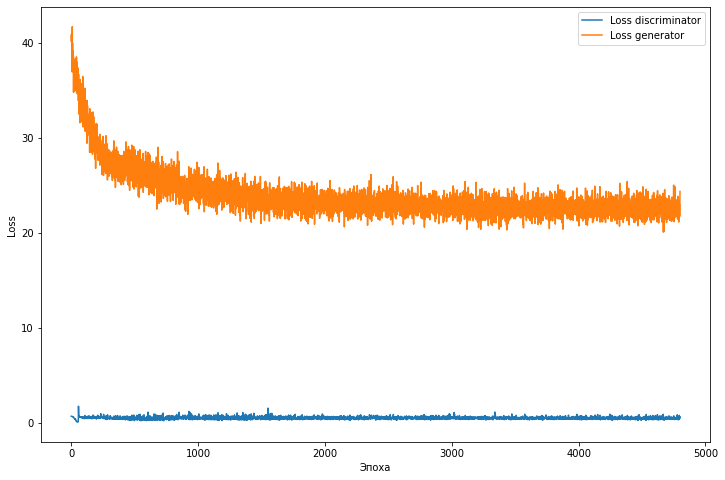

In [33]:
plot_losses(d_losses, g_losses)

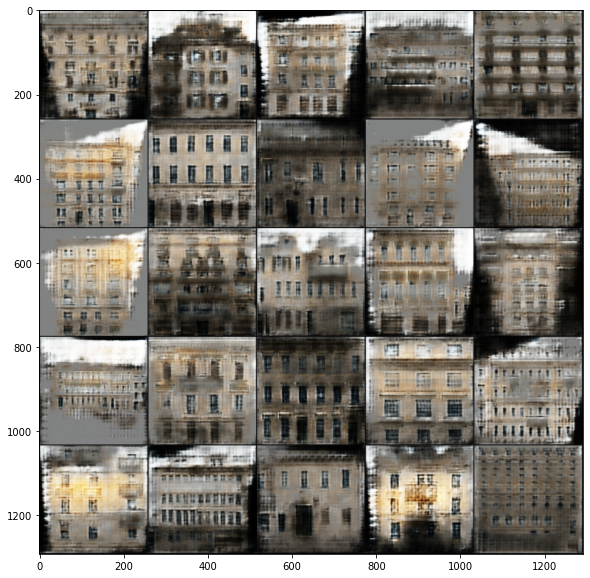

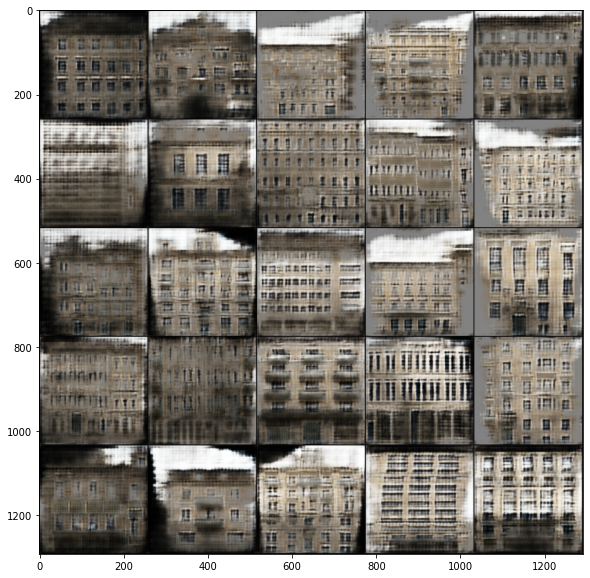

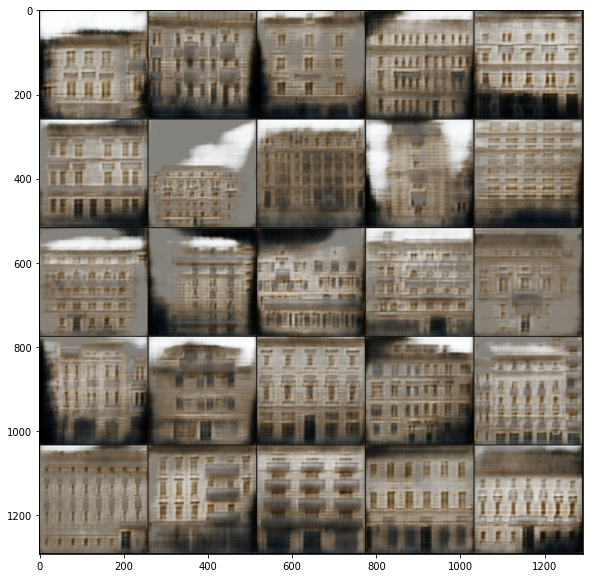

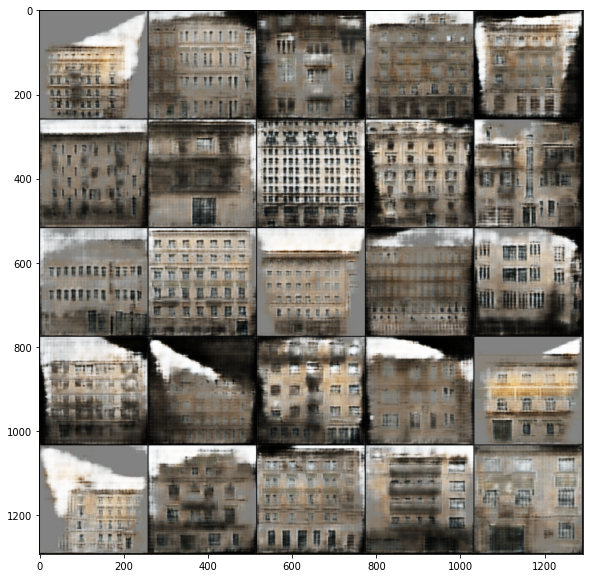

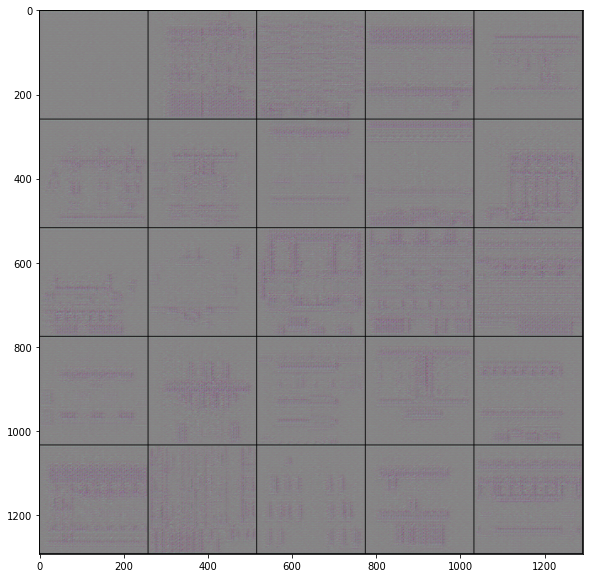

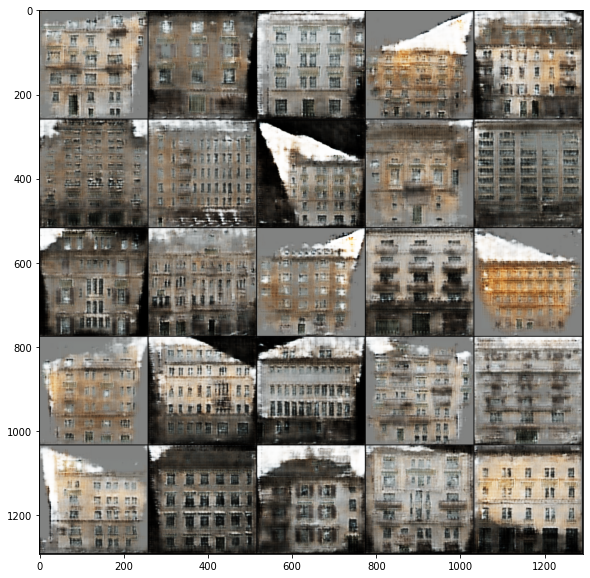

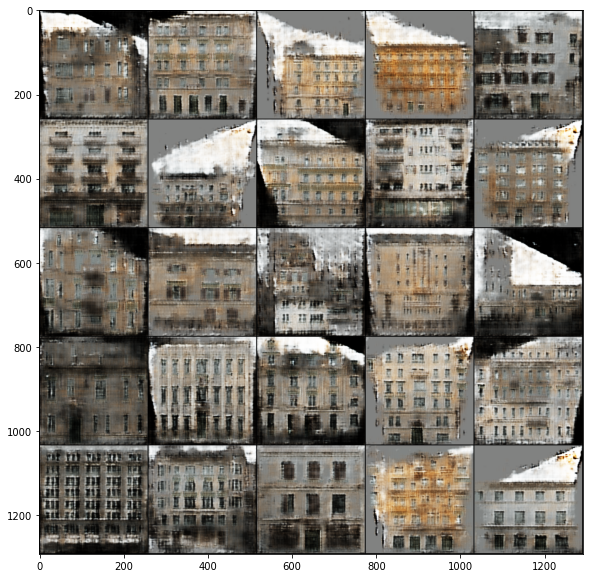

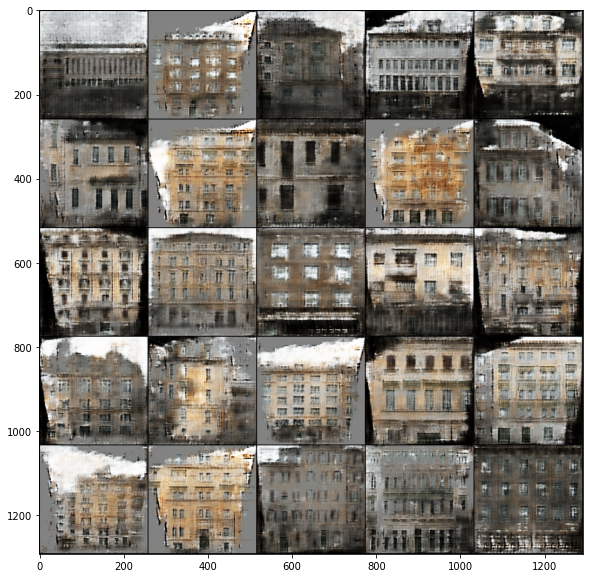

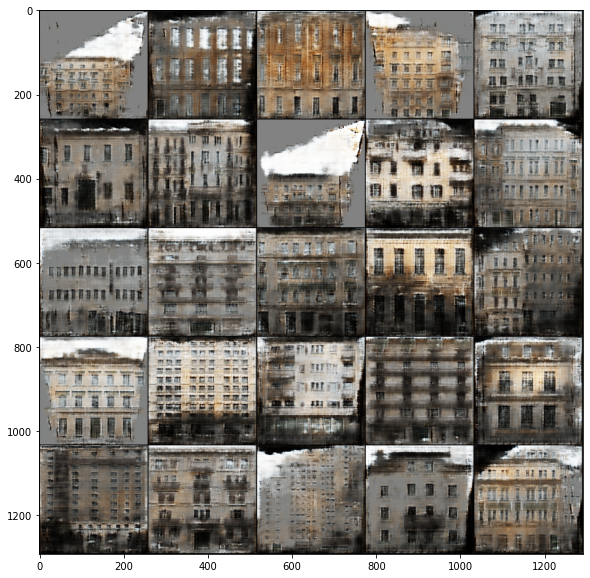

In [34]:
gen_img_list = os.listdir(SAVE_IMG_PATH)
for img_path_idx in range(0, len(gen_img_list), 10):
    image = Image.open(SAVE_IMG_PATH + "/" + gen_img_list[img_path_idx])
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

plt.show()

Вывод: Модель pix2pix обучается, если увеличить количество параметров, учить дольше и поподбирать гиперпараметры, то можно получить изображения лучше.